# Cell-type Classification

In [1]:
import zipfile
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from PIL import Image

Extracting Images from the zip

In [2]:
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Reading the dataframe

In [3]:
data = pd.read_csv('./data_labels_mainData.csv')

In [4]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Check for any null values

Check if to see any null values exists

In [5]:
data.cellTypeName.value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

In [6]:
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [7]:
data.shape
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


Text(0.5, 1.0, 'patient ID')

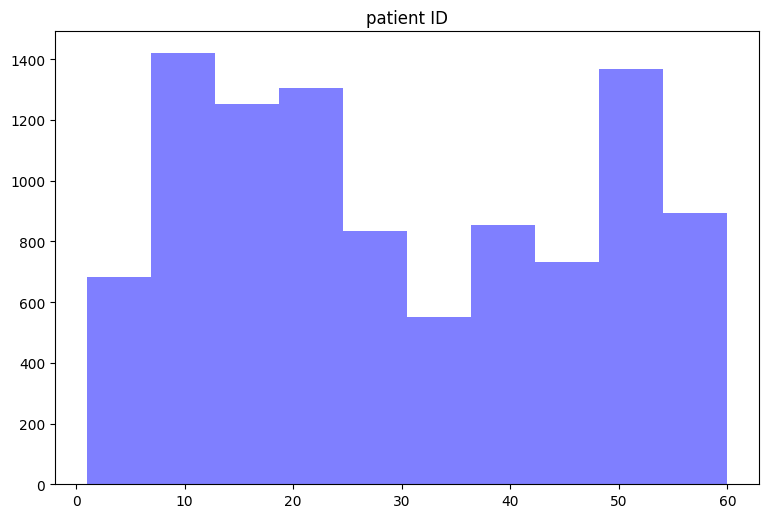

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(3, 2, 1)
plt.hist(data['patientID'], facecolor='blue', alpha=0.5)
plt.title('patient ID')

<Axes: title={'center': 'Frequency of cell types'}, xlabel='Cell Type', ylabel='Number of Images'>

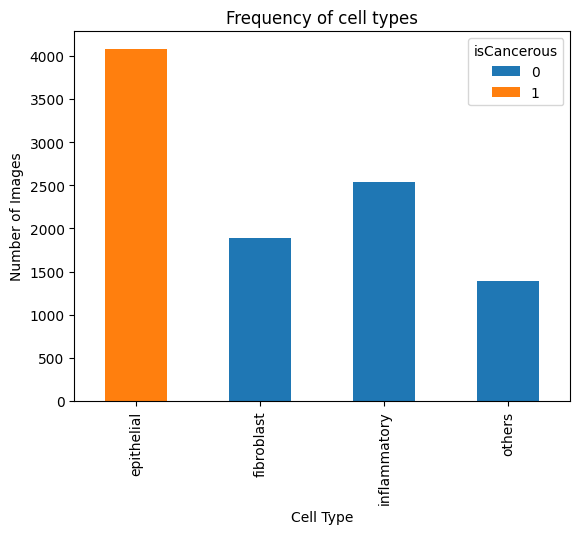

In [9]:
pd.crosstab(data['cellTypeName'], data['isCancerous'], margins=False).plot.bar(stacked=True,
                                                                                         title='Frequency of cell types',
                                                                                         xlabel='Cell Type',
                                                                                         ylabel='Number of Images')

All the cancer cells in the main dataset are of a specific kind called Epithelial. This could be a challenge because there are no cell types in the dataset that have a mix of healthy and cancerous cells. This lack of variety could result in information that might be misleading.

In [10]:
df1 = data.groupby(['cellTypeName', 'cellType'])['InstanceID'].nunique()
df2 = data.groupby(['isCancerous'])['InstanceID'].nunique()
print(df1)
print(df2)

cellTypeName  cellType
epithelial    2           4079
fibroblast    0           1888
inflammatory  1           2543
others        3           1386
Name: InstanceID, dtype: int64
isCancerous
0    5817
1    4079
Name: InstanceID, dtype: int64


In [11]:
label_names = {k: v for k, v in df1.keys()}
cellTypes = {v: k for k, v in label_names.items()}
print(label_names)
print(cellTypes)

{'epithelial': 2, 'fibroblast': 0, 'inflammatory': 1, 'others': 3}
{2: 'epithelial', 0: 'fibroblast', 1: 'inflammatory', 3: 'others'}


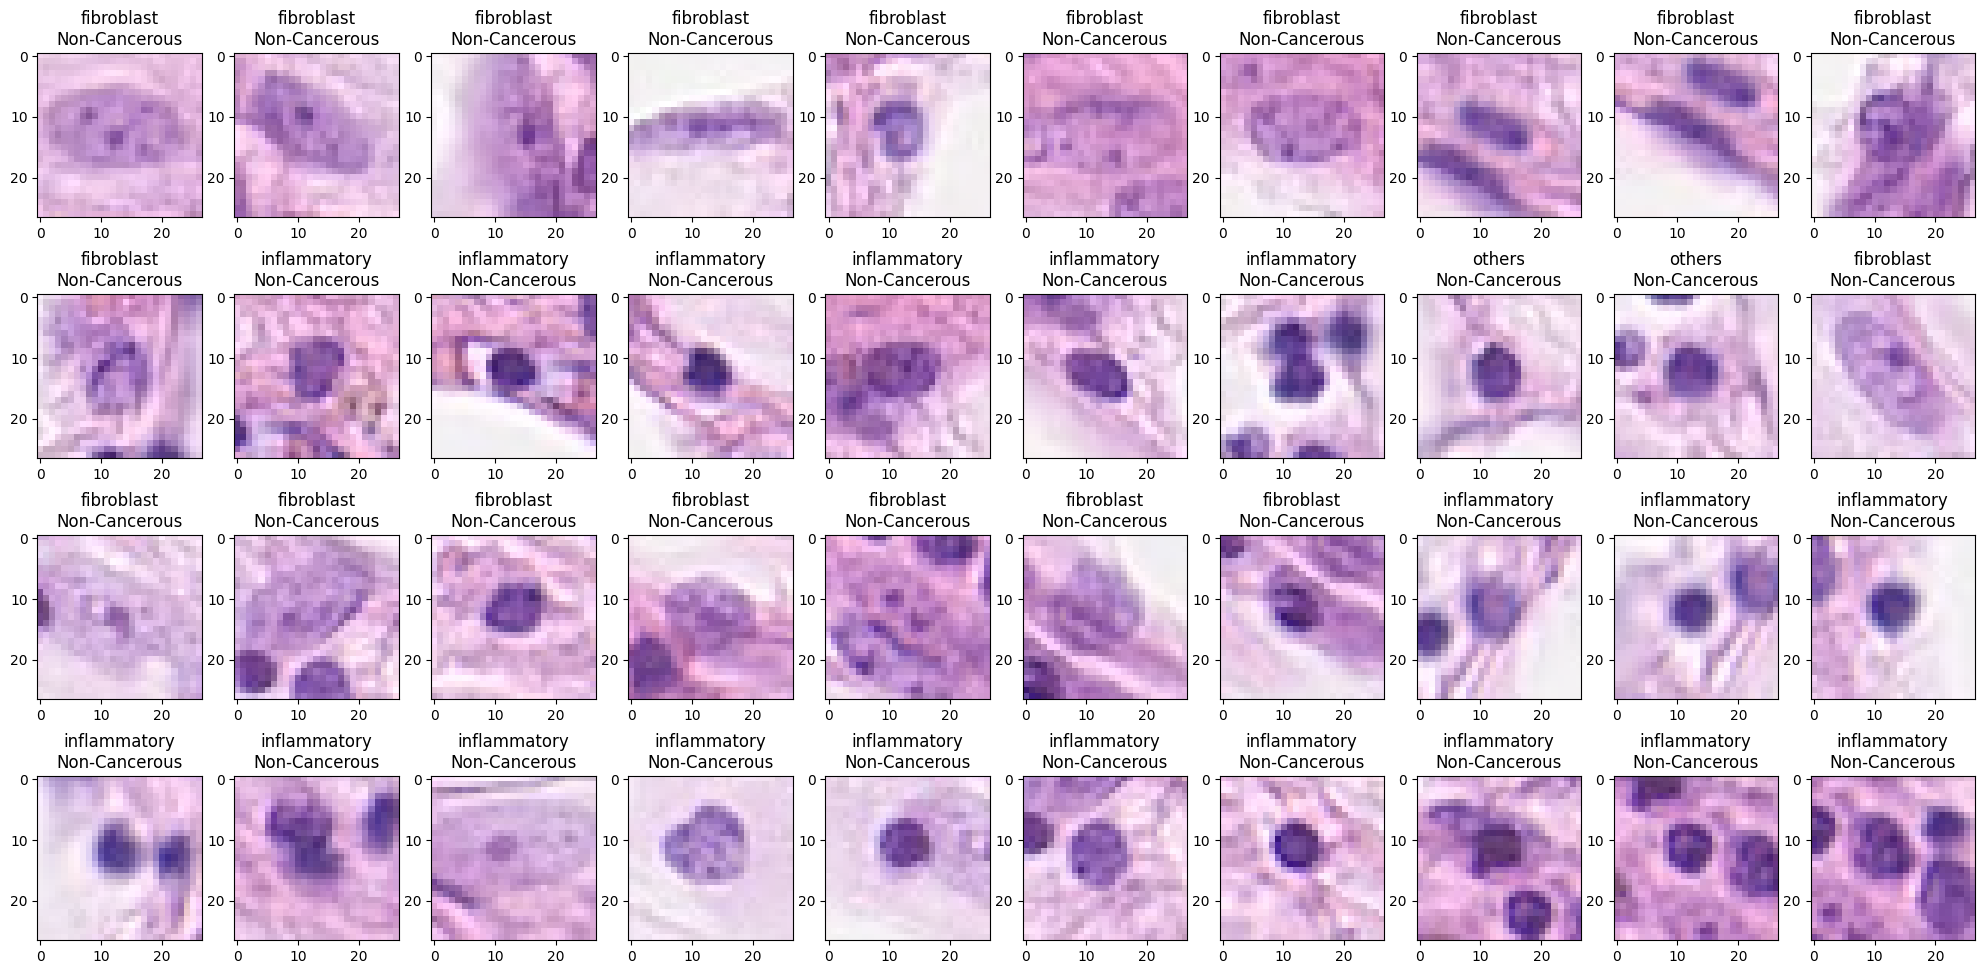

In [12]:
img_list = list(data["ImageName"])
types = list(data["cellType"])
target_list = list(data["isCancerous"])
target_labels = {1: "Cancerous", 0: "Non-Cancerous"}

plt.figure(figsize=[25, 12])

for i in np.arange(40):
    plt.subplot(4, 10, i + 1)
    img = Image.open('./patch_images/' + img_list[i])

    plt.imshow(img)
    plt.title(cellTypes[types[i]] + "\n" + target_labels[target_list[i]])

In [13]:
# Check image sizes
img = Image.open('./patch_images/' + img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print("Image size: \nH:{} W:{} C:{}".format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size: 
H:27 W:27 C:3


## Train test validation split

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


In [15]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')
test_data['cellType'] = test_data['cellType'].astype('str')

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './patch_images/',
    x_col = 'ImageName',
    y_col = "cellType",
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'categorical',
)

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [17]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.12.0'

In [19]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [20]:
def plotConfusionMatrix(y_test,y_pred):

    conf_data = confusion_matrix(y_test,y_pred)
    df_cm = pd.DataFrame(conf_data, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size

    return sns.heatmap(df_cm, cmap="Blues",annot=True,square=True,annot_kws={"size": 16},fmt="g");# font size

early_stopping_monitor = EarlyStopping(patience=10, monitor='val_categorical_accuracy')
def fitModel(model, train_gen=train_generator, val_gen=validation_generator):
    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor],
                            epochs=10000, verbose=1)
    return fit_history

def predictModel(model, generator):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)


def showMetrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = classification_report(y_test, y_pred, zero_division=0)

    print("Accuracy score: ", accuracy_score(y_test, y_pred))
    print("F1 score: ", f1_score(y_test, y_pred, average='macro'))
    print(cm)
    
    


## MLP
 

- Initial baseline NN model
- 4 output classes
- Input is 27x27 RGB(3 channels) images
- 1 hidden layer with 256 internal nodes
- Loss - Categorical Cross Entropy
- Metric - categorical_accuracy
- SGD Optimizer

### Base MLP

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [25]:
history = fitModel(model)

Epoch 1/10000
186/186 [==============================] - 30s 158ms/step - loss: 1.2712 - categorical_accuracy: 0.4639 - val_loss: 1.0627 - val_categorical_accuracy: 0.6109
Epoch 2/10000
186/186 [==============================] - 3s 16ms/step - loss: 1.0767 - categorical_accuracy: 0.5562 - val_loss: 1.0555 - val_categorical_accuracy: 0.4982
Epoch 3/10000
186/186 [==============================] - 3s 16ms/step - loss: 0.9953 - categorical_accuracy: 0.5914 - val_loss: 0.9304 - val_categorical_accuracy: 0.5902
Epoch 4/10000
186/186 [==============================] - 3s 18ms/step - loss: 0.9343 - categorical_accuracy: 0.6234 - val_loss: 0.8952 - val_categorical_accuracy: 0.6620
Epoch 5/10000
186/186 [==============================] - 3s 17ms/step - loss: 0.9092 - categorical_accuracy: 0.6353 - val_loss: 1.0828 - val_categorical_accuracy: 0.5735
Epoch 6/10000
186/186 [==============================] - 3s 18ms/step - loss: 0.8799 - categorical_accuracy: 0.6493 - val_loss: 0.8782 - val_categor

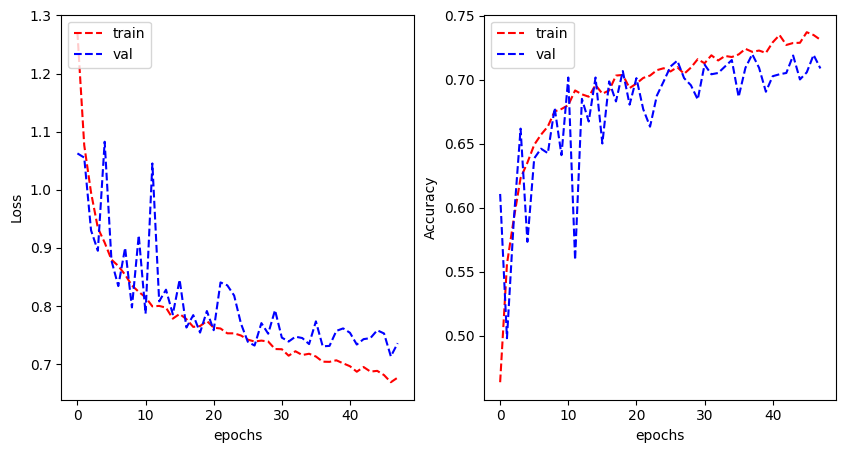

In [26]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [27]:
(train_y, train_pred_y) = predictModel(model, train_generator)

In [28]:
(val_y, val_pred_y) = predictModel(model, validation_generator)

In [29]:
(test_y, test_pred_y) = predictModel(model, test_generator)

In [30]:
showMetrics(train_y, train_pred_y)

Accuracy score:  0.7397938992924192
F1 score:  0.6069434091436415
              precision    recall  f1-score   support

           0       0.58      0.78      0.67     35591
           1       0.73      0.76      0.75     49137
           2       0.83      0.92      0.87     79095
           3       0.84      0.08      0.14     25696

    accuracy                           0.74    189519
   macro avg       0.74      0.64      0.61    189519
weighted avg       0.76      0.74      0.70    189519



In [31]:
showMetrics(val_y, val_pred_y)

Accuracy score:  0.7087204976809713
F1 score:  0.5727121615676907
              precision    recall  f1-score   support

           0       0.56      0.71      0.63     12197
           1       0.67      0.74      0.70     16218
           2       0.81      0.91      0.86     25847
           3       0.68      0.05      0.10      8911

    accuracy                           0.71     63173
   macro avg       0.68      0.61      0.57     63173
weighted avg       0.71      0.71      0.67     63173



In [32]:
showMetrics(test_y, test_pred_y)

Accuracy score:  0.7096432411917263
F1 score:  0.5845227606714642
              precision    recall  f1-score   support

           0       0.58      0.77      0.66     12493
           1       0.67      0.75      0.71     15836
           2       0.81      0.90      0.86     25266
           3       0.70      0.06      0.12      9641

    accuracy                           0.71     63236
   macro avg       0.69      0.62      0.58     63236
weighted avg       0.71      0.71      0.67     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

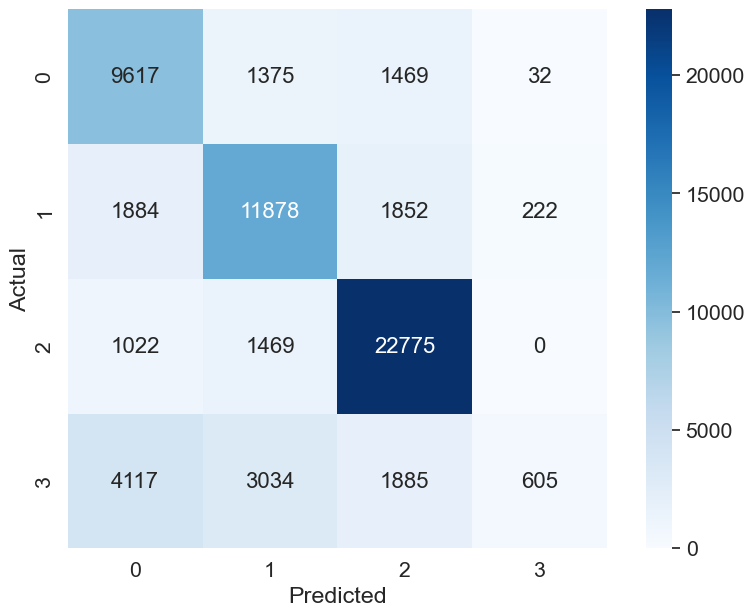

In [33]:
plotConfusionMatrix(test_y, test_pred_y)

- Baseline performed quite well with very slight overfitting. This can be identified from the graph and slight gap between train and val accuracies 
- The performance on class 3 is consistently lower compared to other classes, suggesting that the model struggles to accurately predict this class.
- Class Imbalance: It appears that class 2 has the highest number of samples and generally performs better, while class 3 has the fewest samples and consistently has lower performance. Class imbalance might be a factor contributing to the lower performance on class 3.
- There is room for improvement, particularly in predicting class 3. We may consider exploring techniques such as regularization, adjusting model hyperparameters, or trying more advanced models to improve performance.
- F1-Score and Weighted Average: The weighted average F1-score is 0.61 on the training set, 0.58 on the validation set, and 0.52 on the test set. The weighted average considers both precision and recall and provides a single metric to assess the overall performance of the model across all classes. The decreasing trend in F1-score from training to test set suggests a potential issue of overfitting.

### Trying regularization

- Trying regularization to generalize and improve accuracy

In [34]:
reg_lambda = 0.001

reg_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

reg_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


In [35]:
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2187)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               560128    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [36]:
reg_history = fitModel(reg_model)

Epoch 1/10000
186/186 [==============================] - 10s 51ms/step - loss: 1.7253 - categorical_accuracy: 0.4630 - val_loss: 1.5566 - val_categorical_accuracy: 0.6412
Epoch 2/10000
186/186 [==============================] - 10s 52ms/step - loss: 1.5460 - categorical_accuracy: 0.5461 - val_loss: 1.4325 - val_categorical_accuracy: 0.5897
Epoch 3/10000
186/186 [==============================] - 10s 53ms/step - loss: 1.4465 - categorical_accuracy: 0.5966 - val_loss: 1.4013 - val_categorical_accuracy: 0.6675
Epoch 4/10000
186/186 [==============================] - 10s 55ms/step - loss: 1.4066 - categorical_accuracy: 0.6158 - val_loss: 1.3100 - val_categorical_accuracy: 0.6832
Epoch 5/10000
186/186 [==============================] - 10s 53ms/step - loss: 1.3596 - categorical_accuracy: 0.6414 - val_loss: 1.2889 - val_categorical_accuracy: 0.6857
Epoch 6/10000
186/186 [==============================] - 10s 52ms/step - loss: 1.3380 - categorical_accuracy: 0.6497 - val_loss: 1.2918 - val_cat

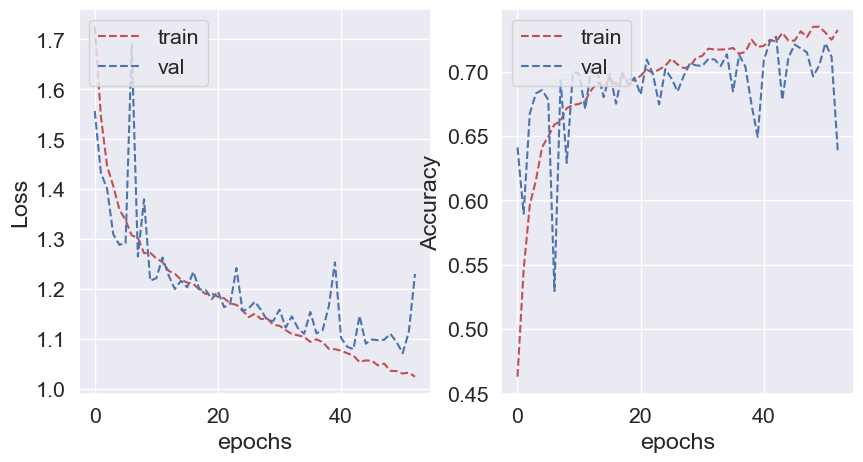

In [37]:
plot_learning_curve(reg_history.history['loss'], reg_history.history['val_loss'], 
                    reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [38]:
(train_y, train_reg_pred_y) = predictModel(reg_model, train_generator)

In [39]:
(val_y, val_reg_pred_y) = predictModel(reg_model, validation_generator)

In [40]:
(test_reg_y, test_reg_pred_y) = predictModel(reg_model, test_generator)

In [41]:
showMetrics(train_y, train_reg_pred_y)

Accuracy score:  0.6747931442080378
F1 score:  0.5341085514461702
              precision    recall  f1-score   support

           0       0.70      0.32      0.44     35600
           1       0.68      0.74      0.71     49138
           2       0.66      0.98      0.79     79079
           3       0.81      0.11      0.19     25687

    accuracy                           0.67    189504
   macro avg       0.71      0.54      0.53    189504
weighted avg       0.70      0.67      0.62    189504



In [42]:
showMetrics(val_y, val_reg_pred_y)

Accuracy score:  0.6384720111448835
F1 score:  0.49549837065743274
              precision    recall  f1-score   support

           0       0.57      0.27      0.37     12192
           1       0.64      0.70      0.67     16206
           2       0.64      0.96      0.77     25856
           3       0.78      0.10      0.18      8914

    accuracy                           0.64     63168
   macro avg       0.66      0.51      0.50     63168
weighted avg       0.65      0.64      0.58     63168



In [43]:
showMetrics(test_reg_y, test_reg_pred_y)

Accuracy score:  0.6488803137651822
F1 score:  0.5167663827225352
              precision    recall  f1-score   support

           0       0.68      0.34      0.45     12487
           1       0.62      0.72      0.67     15833
           2       0.66      0.97      0.78     25258
           3       0.65      0.10      0.17      9654

    accuracy                           0.65     63232
   macro avg       0.65      0.53      0.52     63232
weighted avg       0.65      0.65      0.59     63232



<Axes: xlabel='Predicted', ylabel='Actual'>

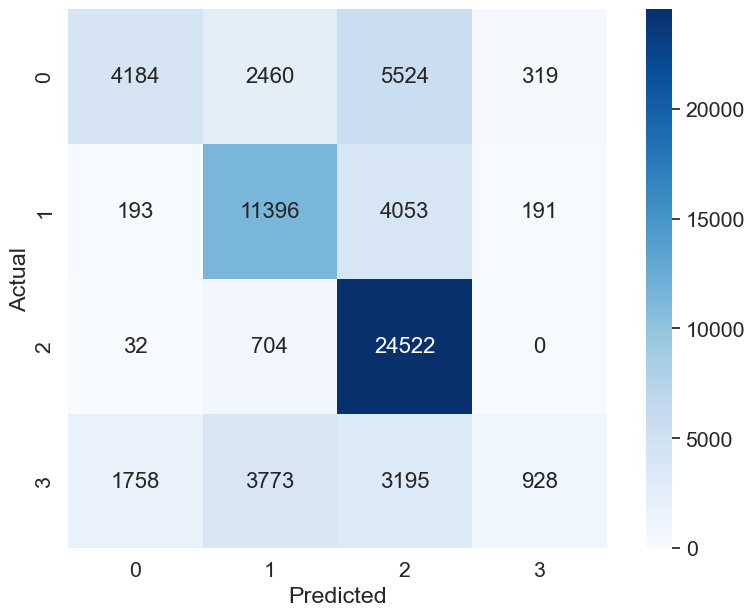

In [44]:
plotConfusionMatrix(test_reg_y, test_reg_pred_y)

The model was regularized but the performance was bad. Hence we can try tuning the hyper parameters to get better performance.

### Hyper Parameter Tuning 

Here we are tuning lambda value for L2 regularization, number of neurons in the hidden layer and the learning rate of the Optimizer

In [45]:
# Define the model-building function
def build_mlp(hp):
    reg_lambda = hp.Choice('reg_lambda', values=[0.001, 0.01, 0.1])
    num_neurons = hp.Choice('num_neurons', values=[128, 256, 512])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])

    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])
    return model

In [48]:
tuner_mlp = RandomSearch(
    build_mlp,
    objective='val_categorical_accuracy',
    max_trials=10,  # Adjust this value as desired
    executions_per_trial=1,
    directory='tuner_directory',  # Provide a directory to store tuner results
    project_name='mlp_hyperparameter_tuning'  # Choose a project name
)

# Perform the hyperparameter search
tuner_mlp.search(train_generator, epochs=25, validation_data=validation_generator)

# Get the best hyperparameters and model architecture
best_mlp_hyperparameters = tuner_mlp.get_best_hyperparameters(num_trials=1)[0]
best_mlp_model = tuner_mlp.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 16s]
val_categorical_accuracy: 0.7054067850112915

Best val_categorical_accuracy So Far: 0.7246083617210388
Total elapsed time: 00h 20m 57s
INFO:tensorflow:Oracle triggered exit


In [49]:
print(best_mlp_hyperparameters)

In [50]:
best_mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_best_mlp = fitModel(best_mlp_model)

Epoch 1/10000
186/186 [==============================] - 6s 29ms/step - loss: 1.1623 - categorical_accuracy: 0.7022 - val_loss: 1.1986 - val_categorical_accuracy: 0.6751
Epoch 2/10000
186/186 [==============================] - 5s 28ms/step - loss: 1.1560 - categorical_accuracy: 0.7094 - val_loss: 1.1489 - val_categorical_accuracy: 0.7059
Epoch 3/10000
186/186 [==============================] - 5s 27ms/step - loss: 1.1543 - categorical_accuracy: 0.7084 - val_loss: 1.1548 - val_categorical_accuracy: 0.7165
Epoch 4/10000
186/186 [==============================] - 5s 28ms/step - loss: 1.1539 - categorical_accuracy: 0.7007 - val_loss: 1.1665 - val_categorical_accuracy: 0.7069
Epoch 5/10000
186/186 [==============================] - 5s 29ms/step - loss: 1.1435 - categorical_accuracy: 0.7128 - val_loss: 1.1403 - val_categorical_accuracy: 0.7115
Epoch 6/10000
186/186 [==============================] - 5s 27ms/step - loss: 1.1423 - categorical_accuracy: 0.7105 - val_loss: 1.1468 - val_categoric

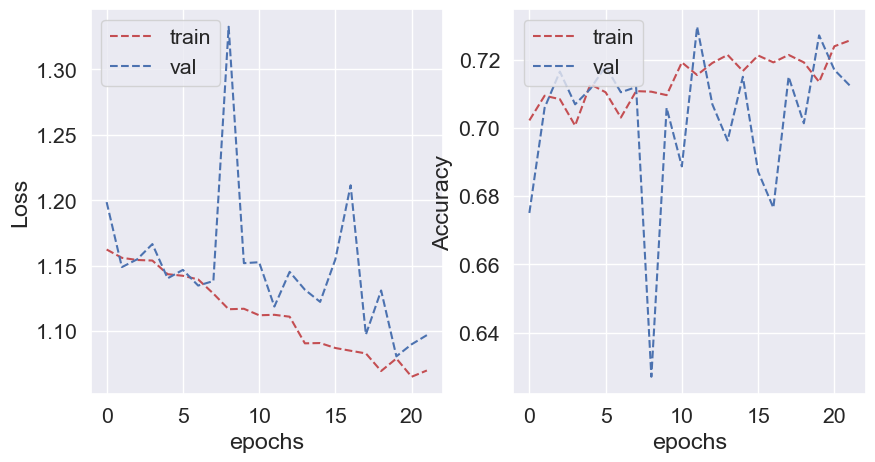

In [52]:
plot_learning_curve(history_best_mlp.history['loss'], history_best_mlp.history['val_loss'], 
                    history_best_mlp.history['categorical_accuracy'], history_best_mlp.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [53]:
(train_y, train_best_mlp_pred_y) = predictModel(best_mlp_model, train_generator)

In [54]:
(val_y, val_best_mlp_pred_y) = predictModel(best_mlp_model, validation_generator)

In [55]:

(test_y, test_best_mlp_pred_y) = predictModel(best_mlp_model, test_generator)

In [56]:
showMetrics(train_y, train_best_mlp_pred_y)

Accuracy score:  0.7395200101317123
F1 score:  0.6319945196807425
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     35568
           1       0.64      0.85      0.73     49132
           2       0.82      0.92      0.87     79106
           3       0.74      0.17      0.28     25698

    accuracy                           0.74    189504
   macro avg       0.73      0.63      0.63    189504
weighted avg       0.74      0.74      0.71    189504



In [57]:
showMetrics(val_y, val_best_mlp_pred_y)

Accuracy score:  0.7127184650455927
F1 score:  0.606116654698751
              precision    recall  f1-score   support

           0       0.65      0.54      0.59     12179
           1       0.60      0.83      0.70     16226
           2       0.81      0.91      0.86     25865
           3       0.81      0.17      0.28      8898

    accuracy                           0.71     63168
   macro avg       0.72      0.61      0.61     63168
weighted avg       0.73      0.71      0.68     63168



In [58]:
showMetrics(test_y, test_best_mlp_pred_y)

Accuracy score:  0.7085810981781376
F1 score:  0.6020100922726322
              precision    recall  f1-score   support

           0       0.69      0.58      0.63     12481
           1       0.59      0.84      0.69     15849
           2       0.82      0.91      0.86     25257
           3       0.64      0.14      0.22      9645

    accuracy                           0.71     63232
   macro avg       0.68      0.62      0.60     63232
weighted avg       0.71      0.71      0.68     63232



<Axes: xlabel='Predicted', ylabel='Actual'>

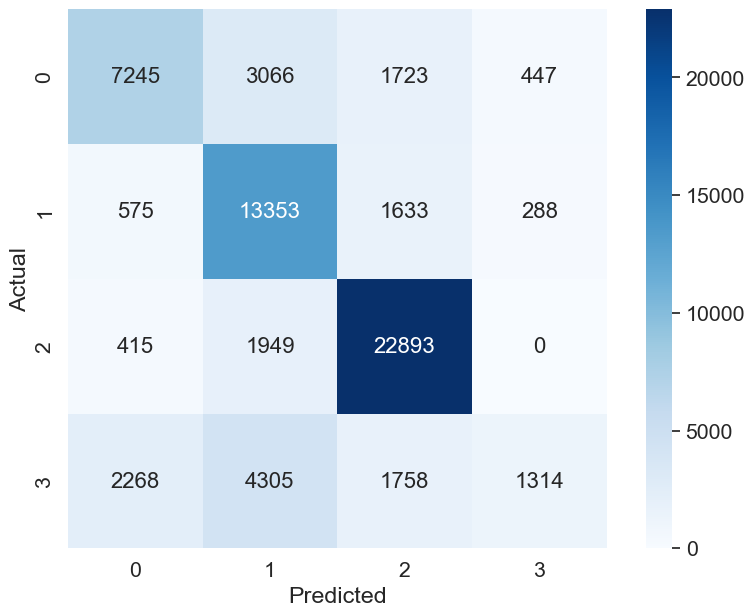

In [59]:
plotConfusionMatrix(test_y, test_best_mlp_pred_y)

Hyper paramter tuning worked as we can see the accuracy improved keeping the model regularized. However, it is worth exploring more complicated models to see if the accuracy can be improved

## VGG

### Base VGG

Here we are implementing basic 3 block VGG

In [21]:
model_VGG = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [22]:
model_VGG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [23]:
tf.keras.utils.plot_model(model_VGG, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model_VGG.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [25]:
history_VGG = fitModel(model_VGG)

Epoch 1/10000
186/186 [==============================] - 9s 46ms/step - loss: 1.3005 - categorical_accuracy: 0.4135 - val_loss: 1.2831 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 9s 47ms/step - loss: 1.2492 - categorical_accuracy: 0.4388 - val_loss: 1.2586 - val_categorical_accuracy: 0.4795
Epoch 3/10000
186/186 [==============================] - 9s 49ms/step - loss: 1.1932 - categorical_accuracy: 0.4794 - val_loss: 1.2126 - val_categorical_accuracy: 0.5063
Epoch 4/10000
186/186 [==============================] - 9s 50ms/step - loss: 1.1162 - categorical_accuracy: 0.5508 - val_loss: 1.0598 - val_categorical_accuracy: 0.5422
Epoch 5/10000
186/186 [==============================] - 9s 49ms/step - loss: 1.0434 - categorical_accuracy: 0.5809 - val_loss: 0.9122 - val_categorical_accuracy: 0.6559
Epoch 6/10000
186/186 [==============================] - 9s 49ms/step - loss: 0.9381 - categorical_accuracy: 0.6279 - val_loss: 0.8468 - val_categoric

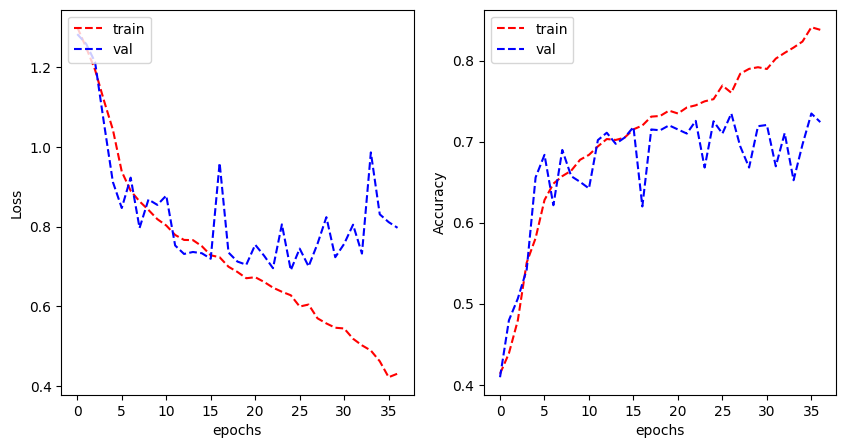

In [26]:
plot_learning_curve(history_VGG.history['loss'], history_VGG.history['val_loss'], 
                    history_VGG.history['categorical_accuracy'], history_VGG.history['val_categorical_accuracy'])

In [27]:
(train_y, train_VGG_pred_y) = predictModel(model_VGG, train_generator)

In [28]:
(val_y, val_VGG_pred_y) = predictModel(model_VGG, validation_generator)

In [29]:
(test_y, test_VGG_pred_y) = predictModel(model_VGG, test_generator)

In [30]:
showMetrics(train_y, train_VGG_pred_y)

Accuracy score:  0.882908837636332
F1 score:  0.8339651987801309
              precision    recall  f1-score   support

           0       0.76      0.91      0.83     35589
           1       0.88      0.92      0.90     49130
           2       0.93      0.98      0.95     79092
           3       0.98      0.49      0.65     25708

    accuracy                           0.88    189519
   macro avg       0.89      0.82      0.83    189519
weighted avg       0.89      0.88      0.88    189519



In [31]:
showMetrics(val_y, val_VGG_pred_y)

Accuracy score:  0.7241226473335127
F1 score:  0.6163893329366357
              precision    recall  f1-score   support

           0       0.59      0.72      0.65     12196
           1       0.70      0.75      0.73     16214
           2       0.82      0.91      0.86     25852
           3       0.62      0.14      0.23      8911

    accuracy                           0.72     63173
   macro avg       0.68      0.63      0.62     63173
weighted avg       0.71      0.72      0.70     63173



In [32]:
showMetrics(test_y, test_VGG_pred_y)

Accuracy score:  0.7045512050098045
F1 score:  0.5979492914670765
              precision    recall  f1-score   support

           0       0.59      0.71      0.64     12489
           1       0.65      0.73      0.69     15846
           2       0.82      0.91      0.86     25256
           3       0.50      0.13      0.20      9645

    accuracy                           0.70     63236
   macro avg       0.64      0.62      0.60     63236
weighted avg       0.68      0.70      0.67     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

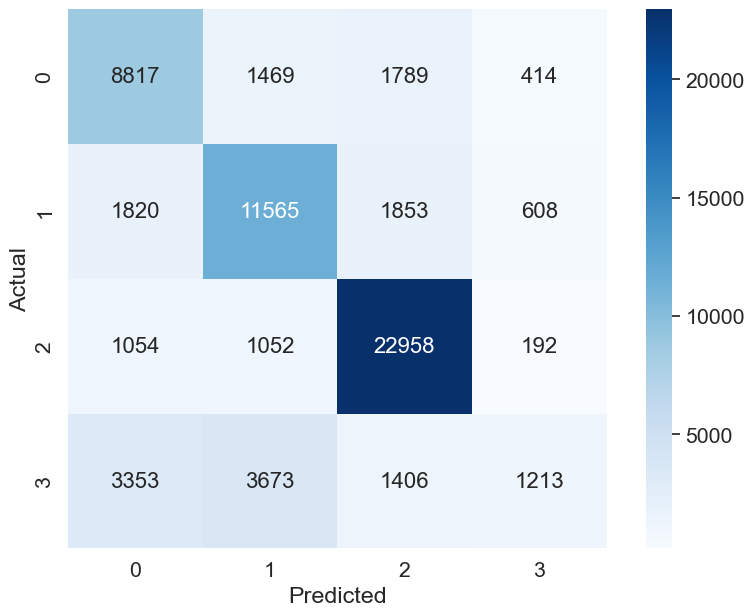

In [35]:
plotConfusionMatrix(test_y, test_VGG_pred_y)

- model accuracy was good with lesser loss than MLP
- shows some overfitting as seen from the graph and gap between accuracies for train and val data

Trying different techniques to overcome overfitting

### Trying Dropout 

In [21]:
model_VGG_dropout = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [22]:
model_VGG_dropout.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [23]:
model_VGG_dropout.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [24]:
history_VGG_dropout = fitModel(model_VGG_dropout)

Epoch 1/10000
186/186 [==============================] - 40s 212ms/step - loss: 1.3101 - categorical_accuracy: 0.4172 - val_loss: 1.2998 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 10s 56ms/step - loss: 1.2836 - categorical_accuracy: 0.4213 - val_loss: 1.2590 - val_categorical_accuracy: 0.4240
Epoch 3/10000
186/186 [==============================] - 10s 55ms/step - loss: 1.2428 - categorical_accuracy: 0.4499 - val_loss: 1.2137 - val_categorical_accuracy: 0.5579
Epoch 4/10000
186/186 [==============================] - 10s 53ms/step - loss: 1.1844 - categorical_accuracy: 0.5056 - val_loss: 1.0970 - val_categorical_accuracy: 0.6003
Epoch 5/10000
186/186 [==============================] - 10s 52ms/step - loss: 1.1135 - categorical_accuracy: 0.5466 - val_loss: 1.0107 - val_categorical_accuracy: 0.6185
Epoch 6/10000
186/186 [==============================] - 10s 53ms/step - loss: 0.9841 - categorical_accuracy: 0.6060 - val_loss: 1.0278 - val_ca

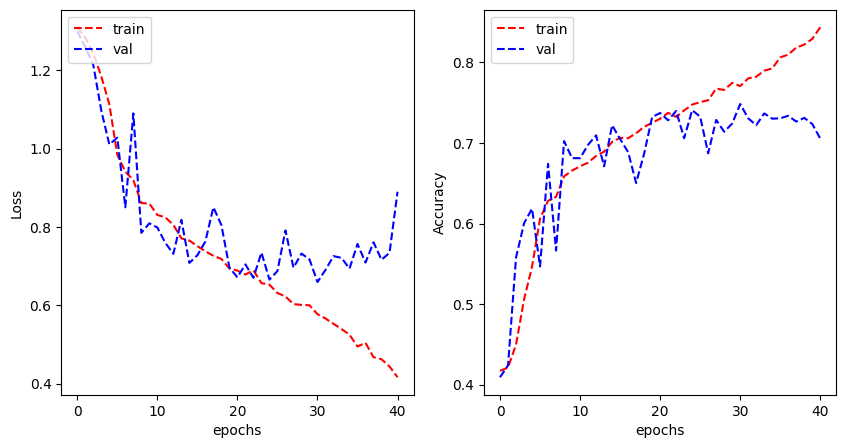

In [25]:
plot_learning_curve(history_VGG_dropout.history['loss'], history_VGG_dropout.history['val_loss'], 
                    history_VGG_dropout.history['categorical_accuracy'], history_VGG_dropout.history['val_categorical_accuracy'])

In [26]:
(train_y, train_VGG_dropout_pred_y) = predictModel(model_VGG_dropout, train_generator)

In [27]:
(val_y, val_VGG_dropout_pred_y) = predictModel(model_VGG_dropout, validation_generator)

In [28]:
(test_y, test_VGG_dropout_pred_y) = predictModel(model_VGG_dropout, test_generator)

In [29]:
showMetrics(train_y, train_VGG_dropout_pred_y)

Accuracy score:  0.8076182335280367
F1 score:  0.7227839190361183
              precision    recall  f1-score   support

           0       0.83      0.58      0.68     35598
           1       0.76      0.94      0.84     49119
           2       0.82      0.99      0.90     79107
           3       0.95      0.31      0.47     25695

    accuracy                           0.81    189519
   macro avg       0.84      0.71      0.72    189519
weighted avg       0.82      0.81      0.78    189519



In [30]:
showMetrics(val_y, val_VGG_dropout_pred_y)

Accuracy score:  0.7053013154353917
F1 score:  0.5724102615468252
              precision    recall  f1-score   support

           0       0.71      0.46      0.56     12196
           1       0.64      0.82      0.72     16224
           2       0.74      0.95      0.83     25843
           3       0.71      0.10      0.17      8910

    accuracy                           0.71     63173
   macro avg       0.70      0.58      0.57     63173
weighted avg       0.71      0.71      0.66     63173



In [31]:
showMetrics(test_y, test_VGG_dropout_pred_y)

Accuracy score:  0.6984787146562085
F1 score:  0.5725497148072766
              precision    recall  f1-score   support

           0       0.69      0.51      0.59     12492
           1       0.63      0.83      0.72     15837
           2       0.75      0.94      0.84     25262
           3       0.53      0.09      0.15      9645

    accuracy                           0.70     63236
   macro avg       0.65      0.59      0.57     63236
weighted avg       0.68      0.70      0.65     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

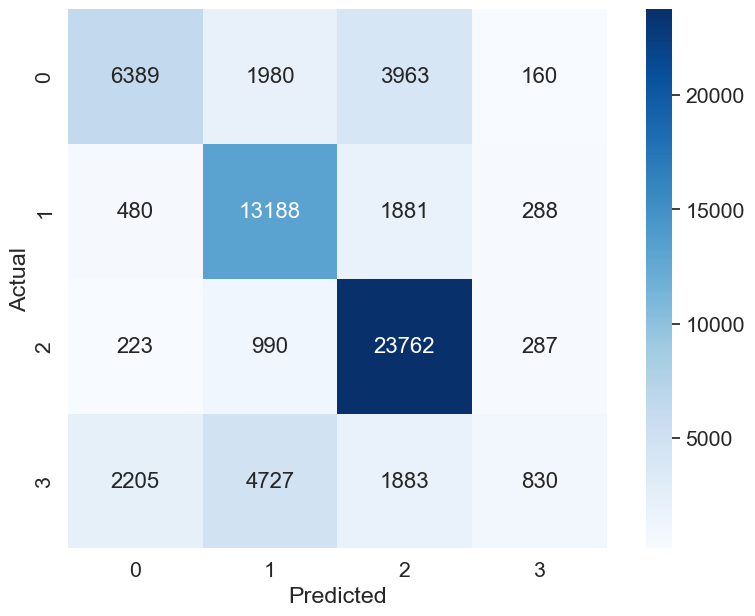

In [32]:
plotConfusionMatrix(test_y, test_VGG_dropout_pred_y)

Seem like Droupout didn't help much with generalizing the model

### Regularization + Dropout

In [20]:
reg_lambda = 0.001

model_VGG_dropout_reg = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [21]:
model_VGG_dropout_reg.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [22]:
model_VGG_dropout_reg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [23]:
history_VGG_dropout_reg = fitModel(model_VGG_dropout_reg)

Epoch 1/10000
186/186 [==============================] - 10s 48ms/step - loss: 1.6663 - categorical_accuracy: 0.4176 - val_loss: 1.6623 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 9s 51ms/step - loss: 1.6499 - categorical_accuracy: 0.4176 - val_loss: 1.6472 - val_categorical_accuracy: 0.4093
Epoch 3/10000
186/186 [==============================] - 9s 50ms/step - loss: 1.6328 - categorical_accuracy: 0.4302 - val_loss: 1.6128 - val_categorical_accuracy: 0.4093
Epoch 4/10000
186/186 [==============================] - 10s 51ms/step - loss: 1.5941 - categorical_accuracy: 0.4521 - val_loss: 1.6345 - val_categorical_accuracy: 0.3825
Epoch 5/10000
186/186 [==============================] - 10s 51ms/step - loss: 1.5606 - categorical_accuracy: 0.4691 - val_loss: 1.7562 - val_categorical_accuracy: 0.4174
Epoch 6/10000
186/186 [==============================] - 10s 55ms/step - loss: 1.4983 - categorical_accuracy: 0.5151 - val_loss: 1.6017 - val_categ

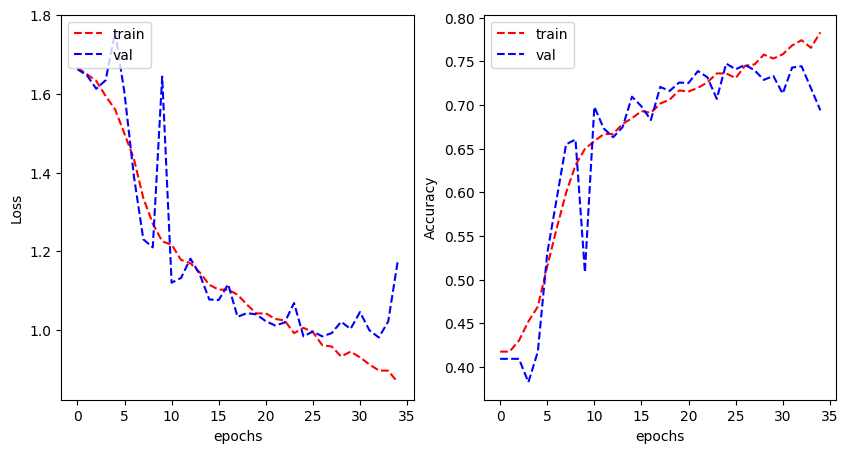

In [24]:
plot_learning_curve(history_VGG_dropout_reg.history['loss'], history_VGG_dropout_reg.history['val_loss'], 
                    history_VGG_dropout_reg.history['categorical_accuracy'], history_VGG_dropout_reg.history['val_categorical_accuracy'])

In [25]:
(train_y, train_VGG_dropout_reg_pred_y) = predictModel(model_VGG_dropout_reg, train_generator)

In [26]:
(val_y, val_VGG_dropout_reg_pred_y) = predictModel(model_VGG_dropout_reg, validation_generator)

In [27]:
(test_y, test_VGG_dropout_reg_pred_y) = predictModel(model_VGG_dropout_reg, test_generator)

In [28]:
showMetrics(train_y, train_VGG_dropout_reg_pred_y)

Accuracy score:  0.7310559891092714
F1 score:  0.5730861876537263
              precision    recall  f1-score   support

           0       0.67      0.54      0.60     35591
           1       0.74      0.83      0.78     49118
           2       0.74      0.98      0.84     79120
           3       0.93      0.03      0.07     25690

    accuracy                           0.73    189519
   macro avg       0.77      0.60      0.57    189519
weighted avg       0.75      0.73      0.68    189519



In [29]:
showMetrics(val_y, val_VGG_dropout_reg_pred_y)

Accuracy score:  0.6937140867142608
F1 score:  0.5352153730738816
              precision    recall  f1-score   support

           0       0.63      0.50      0.56     12199
           1       0.68      0.77      0.72     16210
           2       0.72      0.97      0.83     25860
           3       0.83      0.02      0.03      8904

    accuracy                           0.69     63173
   macro avg       0.71      0.56      0.54     63173
weighted avg       0.71      0.69      0.64     63173



In [30]:
showMetrics(test_y, test_VGG_dropout_reg_pred_y)

Accuracy score:  0.6832500474413309
F1 score:  0.5273750223694083
              precision    recall  f1-score   support

           0       0.62      0.52      0.56     12482
           1       0.65      0.77      0.71     15838
           2       0.72      0.97      0.83     25267
           3       0.66      0.01      0.01      9649

    accuracy                           0.68     63236
   macro avg       0.66      0.57      0.53     63236
weighted avg       0.67      0.68      0.62     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

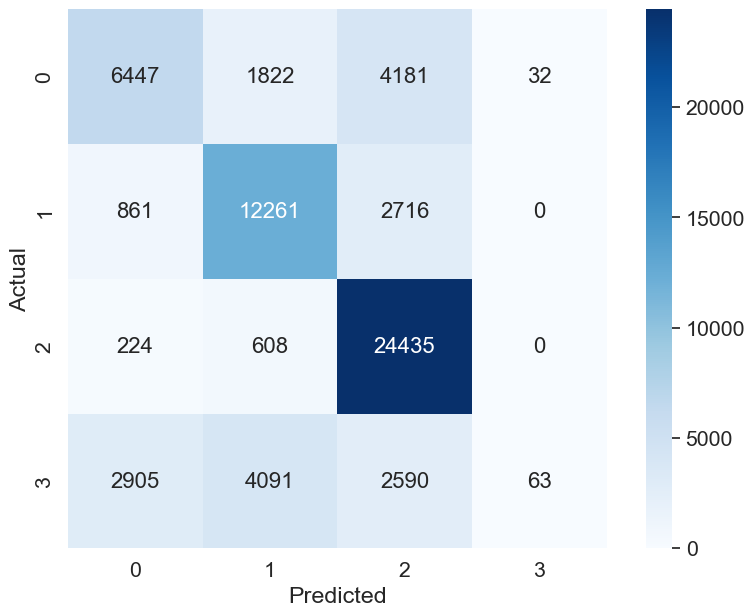

In [31]:
plotConfusionMatrix(test_y, test_VGG_dropout_reg_pred_y)

- model accuracy reduced 
- very minimal effect on overfitting

### Data Augmentation

Data augmentation is a technique used in machine learning and deep learning that involves creating new training examples by applying various transformations to existing data. These transformations can include rotation, scaling, cropping, flipping, or adding noise to the data. Data augmentation helps in reducing overfitting by increasing the size and diversity of the training dataset, allowing the model to learn more robust and generalized representations. By introducing variations in the data, data augmentation helps the model capture different perspectives and variations present in the real-world data, thus improving its ability to generalize well to unseen examples.

In [21]:
aug_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=90, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
aug_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

aug_train_generator = aug_train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images/',
    x_col = 'ImageName',
    y_col = "cellType",
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode='categorical')

aug_validation_generator = aug_val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = './patch_images/',
    x_col = 'ImageName',
    y_col = "cellType",
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [22]:
reg_lambda = 0.001

model_VGG_dropout_reg_aug = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [23]:
model_VGG_dropout_reg_aug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [24]:
model_VGG_dropout_reg_aug.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [25]:
history_VGG_dropout_reg_aug = fitModel(model_VGG_dropout_reg_aug, train_gen = aug_train_generator, val_gen = aug_validation_generator )

Epoch 1/10000
186/186 [==============================] - 40s 212ms/step - loss: 1.6774 - categorical_accuracy: 0.4133 - val_loss: 1.6607 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 10s 54ms/step - loss: 1.6451 - categorical_accuracy: 0.4177 - val_loss: 1.6324 - val_categorical_accuracy: 0.4093
Epoch 3/10000
186/186 [==============================] - 10s 54ms/step - loss: 1.6069 - categorical_accuracy: 0.4384 - val_loss: 1.5426 - val_categorical_accuracy: 0.4396
Epoch 4/10000
186/186 [==============================] - 11s 58ms/step - loss: 1.5493 - categorical_accuracy: 0.4765 - val_loss: 1.5110 - val_categorical_accuracy: 0.4750
Epoch 5/10000
186/186 [==============================] - 13s 67ms/step - loss: 1.4745 - categorical_accuracy: 0.5371 - val_loss: 1.5875 - val_categorical_accuracy: 0.4755
Epoch 6/10000
186/186 [==============================] - 13s 68ms/step - loss: 1.3950 - categorical_accuracy: 0.5813 - val_loss: 1.2600 - val_ca

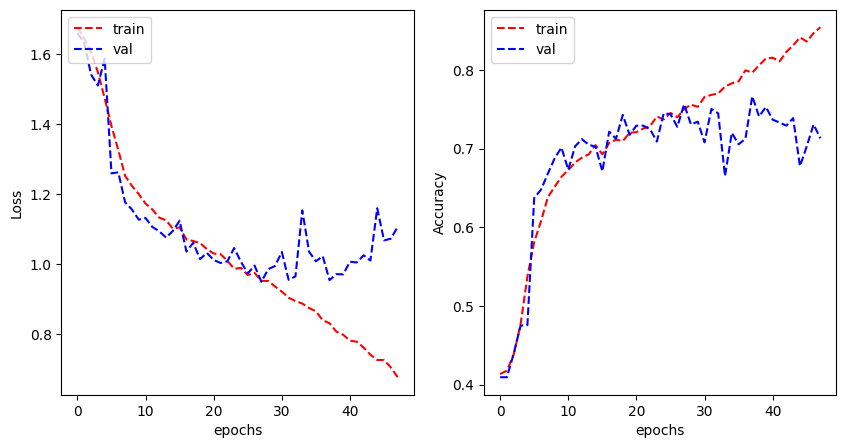

In [26]:
plot_learning_curve(history_VGG_dropout_reg_aug.history['loss'], history_VGG_dropout_reg_aug.history['val_loss'], 
                    history_VGG_dropout_reg_aug.history['categorical_accuracy'], history_VGG_dropout_reg_aug.history['val_categorical_accuracy'])

In [27]:
(train_y, train_VGG_dropout_reg_aug_pred_y) = predictModel(model_VGG_dropout_reg_aug, train_generator)

In [28]:
(val_y, val_VGG_dropout_reg_aug_pred_y) = predictModel(model_VGG_dropout_reg_aug, validation_generator)

In [29]:
(test_y, test_VGG_dropout_reg_aug_pred_y) = predictModel(model_VGG_dropout_reg_aug, test_generator)

In [30]:
showMetrics(train_y, train_VGG_dropout_reg_aug_pred_y)

Accuracy score:  0.8894833763369372
F1 score:  0.8550592469826296
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     35592
           1       0.95      0.85      0.89     49126
           2       0.92      0.99      0.95     79104
           3       0.89      0.62      0.73     25697

    accuracy                           0.89    189519
   macro avg       0.88      0.85      0.86    189519
weighted avg       0.90      0.89      0.89    189519



In [31]:
showMetrics(val_y, val_VGG_dropout_reg_aug_pred_y)

Accuracy score:  0.7129786459405125
F1 score:  0.6304434797952864
              precision    recall  f1-score   support

           0       0.57      0.73      0.64     12201
           1       0.74      0.60      0.67     16205
           2       0.80      0.93      0.86     25862
           3       0.56      0.27      0.36      8905

    accuracy                           0.71     63173
   macro avg       0.67      0.63      0.63     63173
weighted avg       0.71      0.71      0.70     63173



In [32]:
showMetrics(test_y, test_VGG_dropout_reg_aug_pred_y)

Accuracy score:  0.7157157315453223
F1 score:  0.6351818756521675
              precision    recall  f1-score   support

           0       0.60      0.74      0.66     12487
           1       0.72      0.64      0.68     15840
           2       0.81      0.93      0.86     25262
           3       0.52      0.25      0.34      9647

    accuracy                           0.72     63236
   macro avg       0.66      0.64      0.64     63236
weighted avg       0.70      0.72      0.70     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

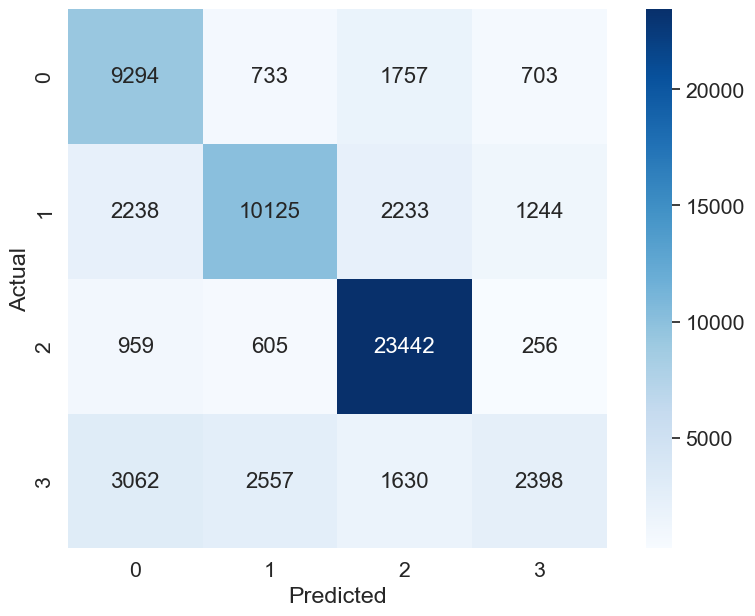

In [33]:
plotConfusionMatrix(test_y, test_VGG_dropout_reg_aug_pred_y)

Very minimal effect on overfitting

### Hyper Paramter Tuning

In [22]:
def build_model(hp):
    reg_lambda = hp.Choice('reg_lambda', values=[0.001, 0.01])
    dropout_rate = hp.Choice('dropout_rate',values=[0.1, 0.2])
    
    model = tf.keras.Sequential([
        # VGG block 1
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # VGG block 2
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        #VGG block 3
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
    ])

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01])),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['categorical_accuracy'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_categorical_accuracy',
    max_trials=6,  # Adjust this value as desired
    executions_per_trial=1,
    directory='tuner_directory',  # Provide a directory to store tuner results
    project_name='vgg_hyperparameter_tuning'  # Choose a project name
)

# Perform the hyperparameter search
tuner.search(aug_train_generator, epochs=25, validation_data=aug_validation_generator)

# Get the best hyperparameters and model architecture
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Reloading Tuner from tuner_directory\vgg_hyperparameter_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [24]:
print(best_hyperparameters)

In [25]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                    

In [26]:
history_best = fitModel(best_model, train_gen = aug_train_generator, val_gen = aug_validation_generator )

Epoch 1/10000
186/186 [==============================] - 39s 203ms/step - loss: 1.1075 - categorical_accuracy: 0.6867 - val_loss: 1.2009 - val_categorical_accuracy: 0.6246
Epoch 2/10000
186/186 [==============================] - 9s 51ms/step - loss: 1.0775 - categorical_accuracy: 0.6928 - val_loss: 0.9990 - val_categorical_accuracy: 0.7241
Epoch 3/10000
186/186 [==============================] - 9s 51ms/step - loss: 1.0713 - categorical_accuracy: 0.7000 - val_loss: 1.0077 - val_categorical_accuracy: 0.7266
Epoch 4/10000
186/186 [==============================] - 9s 50ms/step - loss: 1.0535 - categorical_accuracy: 0.7079 - val_loss: 0.9964 - val_categorical_accuracy: 0.7216
Epoch 5/10000
186/186 [==============================] - 9s 51ms/step - loss: 1.0408 - categorical_accuracy: 0.7132 - val_loss: 1.0038 - val_categorical_accuracy: 0.7347
Epoch 6/10000
186/186 [==============================] - 10s 53ms/step - loss: 1.0273 - categorical_accuracy: 0.7140 - val_loss: 1.0055 - val_catego

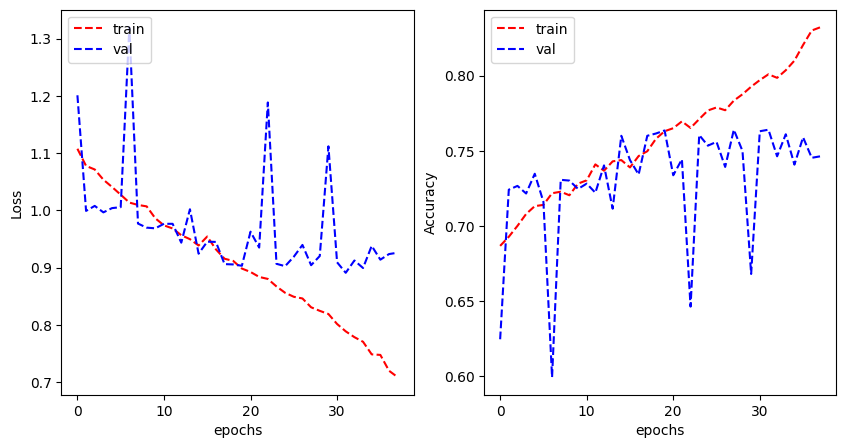

In [27]:
plot_learning_curve(history_best.history['loss'], history_best.history['val_loss'], 
                    history_best.history['categorical_accuracy'], history_best.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [28]:
(train_y, train_best_pred_y) = predictModel(best_model, train_generator)

In [29]:
(val_y, val_best_pred_y) = predictModel(best_model, validation_generator)

In [30]:

(test_y, test_best_pred_y) = predictModel(best_model, test_generator)

In [31]:
showMetrics(train_y, train_best_pred_y)

Accuracy score:  0.8799170531714499
F1 score:  0.851353984035517
              precision    recall  f1-score   support

           0       0.77      0.89      0.83     35602
           1       0.88      0.90      0.89     49132
           2       0.96      0.92      0.94     79090
           3       0.81      0.70      0.75     25695

    accuracy                           0.88    189519
   macro avg       0.85      0.85      0.85    189519
weighted avg       0.88      0.88      0.88    189519



In [32]:
showMetrics(val_y, val_best_pred_y)

Accuracy score:  0.7463631614772134
F1 score:  0.6775114890674492
              precision    recall  f1-score   support

           0       0.63      0.75      0.68     12195
           1       0.70      0.76      0.73     16218
           2       0.91      0.88      0.89     25863
           3       0.51      0.34      0.41      8897

    accuracy                           0.75     63173
   macro avg       0.69      0.68      0.68     63173
weighted avg       0.74      0.75      0.74     63173



In [33]:
showMetrics(test_y, test_best_pred_y)

Accuracy score:  0.7302169650199254
F1 score:  0.6722835404356133
              precision    recall  f1-score   support

           0       0.65      0.75      0.70     12486
           1       0.68      0.73      0.70     15846
           2       0.91      0.86      0.88     25258
           3       0.45      0.37      0.41      9646

    accuracy                           0.73     63236
   macro avg       0.67      0.68      0.67     63236
weighted avg       0.73      0.73      0.73     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

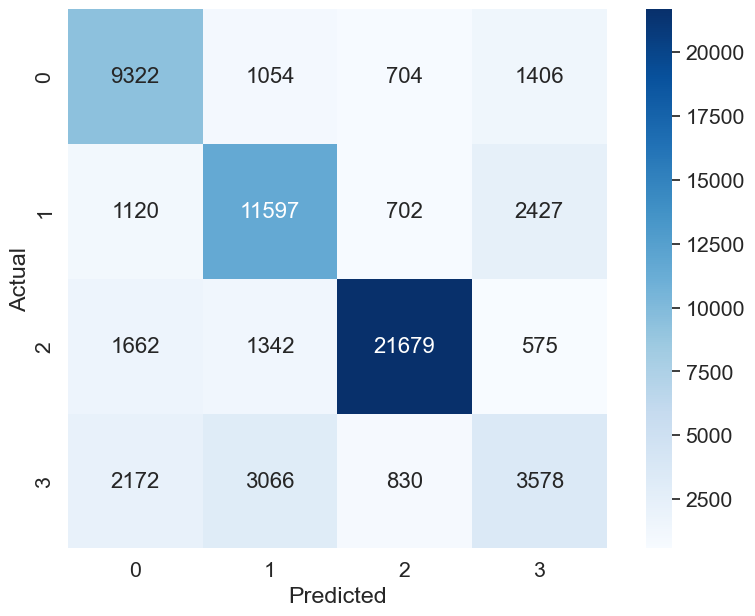

In [34]:
plotConfusionMatrix(test_y, test_best_pred_y)

- The model achieved the highest accuracy compared to other models tested.
- It demonstrates better generalization, as evidenced.
- The model shows improved performance in terms of accuracy and F1 score, indicating its effectiveness in correctly classifying instances.
- The regularization technique applied has helped mitigate overfitting, resulting in improved generalization.
- The model's ability to generalize well is supported by its performance on unseen data, suggesting it can handle real-world scenarios.

## Lenet

### Base Lenet

In [21]:
model_leNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [22]:
model_leNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 27, 27, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 32)        320       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 32)        0         
                                                        

In [23]:
tf.keras.utils.plot_model(model_leNet, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
model_leNet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [25]:
history_leNet = fitModel(model_leNet)

Epoch 1/10000
186/186 [==============================] - 35s 188ms/step - loss: 1.3154 - categorical_accuracy: 0.4157 - val_loss: 1.3086 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 4s 22ms/step - loss: 1.2938 - categorical_accuracy: 0.4181 - val_loss: 1.2990 - val_categorical_accuracy: 0.4507
Epoch 3/10000
186/186 [==============================] - 4s 22ms/step - loss: 1.2732 - categorical_accuracy: 0.4307 - val_loss: 1.2613 - val_categorical_accuracy: 0.4957
Epoch 4/10000
186/186 [==============================] - 4s 24ms/step - loss: 1.2228 - categorical_accuracy: 0.4991 - val_loss: 1.1720 - val_categorical_accuracy: 0.5604
Epoch 5/10000
186/186 [==============================] - 4s 22ms/step - loss: 1.1347 - categorical_accuracy: 0.5474 - val_loss: 1.0517 - val_categorical_accuracy: 0.5801
Epoch 6/10000
186/186 [==============================] - 4s 22ms/step - loss: 1.0382 - categorical_accuracy: 0.5811 - val_loss: 1.0106 - val_categor

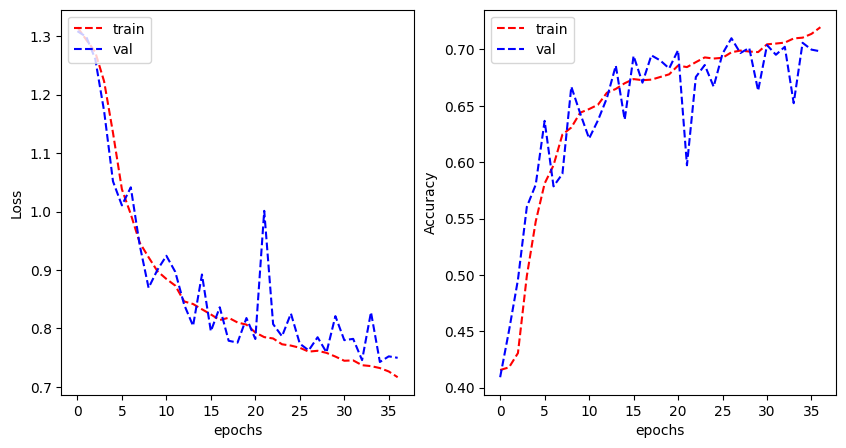

In [26]:
plot_learning_curve(history_leNet.history['loss'], history_leNet.history['val_loss'], 
                    history_leNet.history['categorical_accuracy'], history_leNet.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [29]:
(train_y, train_leNet_pred_y) = predictModel(model_leNet, train_generator)

In [31]:
(val_y, val_leNet_pred_y) = predictModel(model_leNet, validation_generator)

In [27]:
(test_y, test_leNet_pred_y) = predictModel(model_leNet, test_generator)

In [30]:
showMetrics(train_y, train_leNet_pred_y)

Accuracy score:  0.7224341622739673
F1 score:  0.6017017352737561
              precision    recall  f1-score   support

           0       0.56      0.76      0.64     35590
           1       0.71      0.80      0.75     49129
           2       0.83      0.86      0.85     79103
           3       0.56      0.09      0.16     25697

    accuracy                           0.72    189519
   macro avg       0.67      0.63      0.60    189519
weighted avg       0.71      0.72      0.69    189519



In [32]:
showMetrics(val_y, val_leNet_pred_y)

Accuracy score:  0.6982571668276004
F1 score:  0.5783815570184162
              precision    recall  f1-score   support

           0       0.54      0.74      0.63     12187
           1       0.68      0.78      0.73     16225
           2       0.82      0.84      0.83     25850
           3       0.47      0.08      0.13      8911

    accuracy                           0.70     63173
   macro avg       0.63      0.61      0.58     63173
weighted avg       0.68      0.70      0.67     63173



In [28]:
showMetrics(test_y, test_leNet_pred_y)

Accuracy score:  0.6777626668353469
F1 score:  0.556266468413713
              precision    recall  f1-score   support

           0       0.54      0.71      0.61     12482
           1       0.65      0.79      0.71     15840
           2       0.80      0.83      0.82     25268
           3       0.34      0.05      0.08      9646

    accuracy                           0.68     63236
   macro avg       0.58      0.59      0.56     63236
weighted avg       0.64      0.68      0.64     63236



<Axes: xlabel='Predicted', ylabel='Actual'>

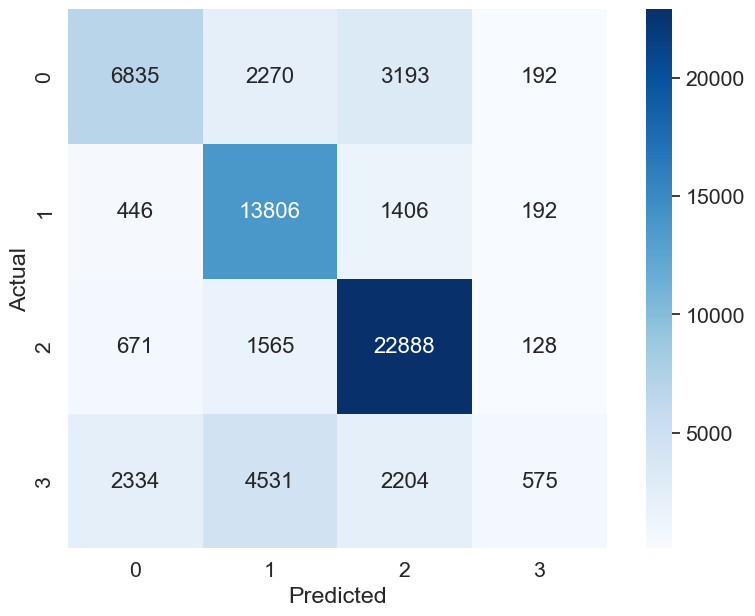

In [33]:
plotConfusionMatrix(test_y, test_leNet_pred_y)


- Accuracy is worse than VGG
- better fitted than VGG

### Regularization + Dropout

In [34]:
reg_lambda = 0.001

model_leNet_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_DIM),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [35]:
model_leNet_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 27, 27, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 32)        320       
                                                                 
 activation_4 (Activation)   (None, 25, 25, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 activation_5 (Activation)   (None, 10, 10, 32)        0         
                                                      

In [36]:
model_leNet_reg.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [37]:
history_leNet_reg = fitModel(model_leNet_reg)

Epoch 1/10000
186/186 [==============================] - 19s 102ms/step - loss: 1.3746 - categorical_accuracy: 0.4039 - val_loss: 1.3532 - val_categorical_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 18s 96ms/step - loss: 1.3477 - categorical_accuracy: 0.4176 - val_loss: 1.3451 - val_categorical_accuracy: 0.4093
Epoch 3/10000
186/186 [==============================] - 17s 93ms/step - loss: 1.3379 - categorical_accuracy: 0.4177 - val_loss: 1.3374 - val_categorical_accuracy: 0.4093
Epoch 4/10000
186/186 [==============================] - 17s 93ms/step - loss: 1.3246 - categorical_accuracy: 0.4206 - val_loss: 1.3189 - val_categorical_accuracy: 0.4093
Epoch 5/10000
186/186 [==============================] - 17s 93ms/step - loss: 1.3033 - categorical_accuracy: 0.4455 - val_loss: 1.2878 - val_categorical_accuracy: 0.4164
Epoch 6/10000
186/186 [==============================] - 17s 92ms/step - loss: 1.2582 - categorical_accuracy: 0.5051 - val_loss: 1.2112 - val_ca

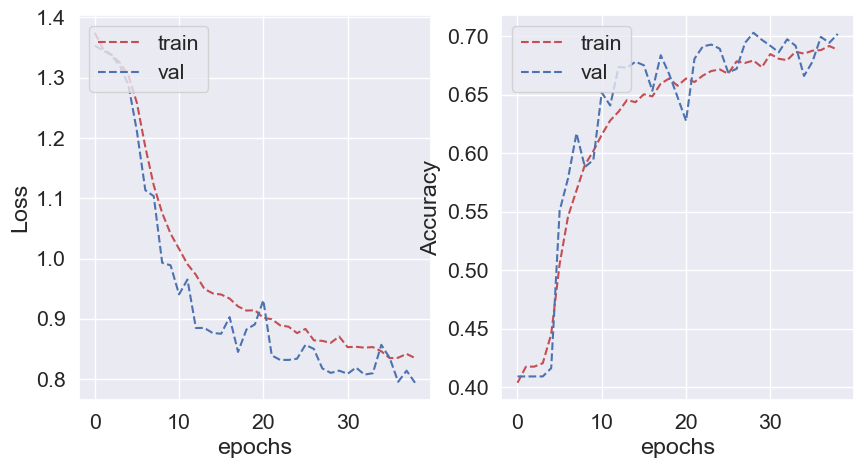

In [38]:
plot_learning_curve(history_leNet_reg.history['loss'], history_leNet_reg.history['val_loss'], 
                    history_leNet_reg.history['categorical_accuracy'], history_leNet_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [39]:
(train_y, train_leNet_reg_pred_y) = predictModel(model_leNet_reg, train_generator)

In [40]:
(val_y, val_leNet_reg_pred_y) = predictModel(model_leNet_reg, validation_generator)

In [41]:
(test_y, test_leNet_reg_pred_y) = predictModel(model_leNet_reg, test_generator)

In [42]:
showMetrics(train_y, train_leNet_reg_pred_y)

Accuracy score:  0.7110615079365079
F1 score:  0.5692950185244506
              precision    recall  f1-score   support

           0       0.58      0.70      0.63     35600
           1       0.64      0.86      0.73     49120
           2       0.85      0.85      0.85     79077
           3       0.51      0.03      0.06     25707

    accuracy                           0.71    189504
   macro avg       0.64      0.61      0.57    189504
weighted avg       0.70      0.71      0.67    189504



In [43]:
showMetrics(val_y, val_leNet_reg_pred_y)

Accuracy score:  0.7017160587639311
F1 score:  0.5618745560797659
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     12195
           1       0.63      0.88      0.73     16221
           2       0.84      0.83      0.84     25849
           3       0.40      0.03      0.05      8903

    accuracy                           0.70     63168
   macro avg       0.61      0.60      0.56     63168
weighted avg       0.67      0.70      0.66     63168



In [44]:
showMetrics(test_y, test_leNet_reg_pred_y)

Accuracy score:  0.6735039220647774
F1 score:  0.5385366494793273
              precision    recall  f1-score   support

           0       0.55      0.63      0.59     12481
           1       0.60      0.87      0.71     15830
           2       0.82      0.82      0.82     25270
           3       0.33      0.02      0.04      9651

    accuracy                           0.67     63232
   macro avg       0.58      0.59      0.54     63232
weighted avg       0.64      0.67      0.63     63232



<Axes: xlabel='Predicted', ylabel='Actual'>

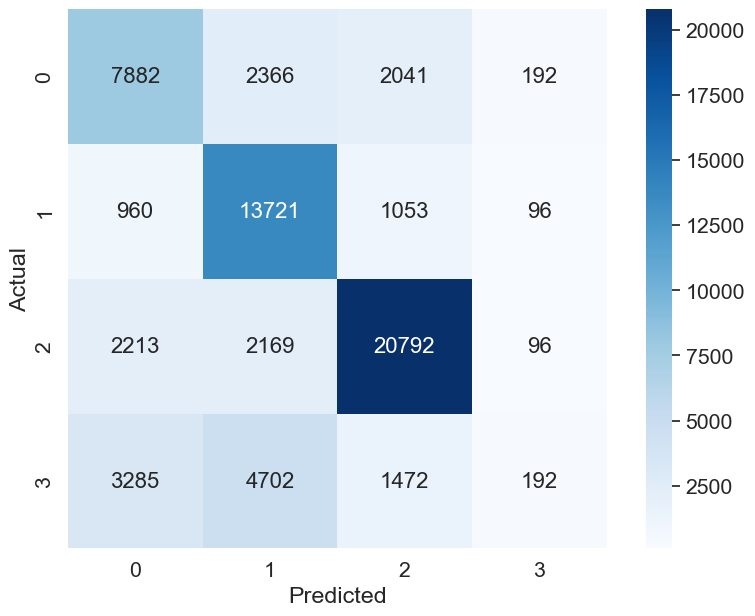

In [45]:
plotConfusionMatrix(test_y, test_leNet_reg_pred_y)

Still the accuracy is very less compared to the tuned VGG model.

<b>Overall, our best model for this task is the VGG - 3 Block + Dropout + Regularisation + Data Augmentation + Hyperparameter Tuned Model </b> 

## Improving Cell-type classification using Pseudo labelling

Pseudo labelling is a technique used in semi-supervised learning, where a model trained on labeled data is used to predict labels for unlabeled data. These predicted labels are then combined with the original labeled data, creating a larger dataset with both labeled and pseudo-labeled examples

In [30]:
# Import extra dataset
extra_data = pd.read_csv('./data_labels_extraData.csv')
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


In [31]:
# Check for missing values in main dataset
extra_data.isna().sum()

InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64

In [32]:
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 32

extra_datagen = extra_datagen.flow_from_dataframe(
        dataframe=extra_data,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
       class_mode=None)


Found 10384 validated image filenames.


Predicting the labels for extra data

In [34]:
y_pred = best_model.predict(extra_datagen)

325/325 [==============================] - 38s 118ms/step


In [36]:
y_pred = np.argmax(y_pred, axis = 1)

In [37]:
print(y_pred)

[1 2 1 ... 2 1 1]


In [38]:
extra_data['cellType'] = y_pred

In [39]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,1
1,12682,61,12682.png,0,2
2,12683,61,12683.png,0,1
3,12684,61,12684.png,0,1
4,12685,61,12685.png,0,2


In [40]:
merged_data = pd.concat([train_data, extra_data], axis=0)

In [41]:
merged_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9533,22266,58,22266.png,fibroblast,0,0
310,18717,4,18717.png,others,3,0
9480,21202,57,21202.png,inflammatory,1,0
7073,18114,44,18114.png,fibroblast,0,0
8977,14070,54,14070.png,epithelial,2,1
...,...,...,...,...,...,...
10379,20028,99,20028.png,NaN,2,0
10380,20029,99,20029.png,NaN,0,0
10381,20030,99,20030.png,NaN,2,0
10382,20031,99,20031.png,NaN,1,0


In [42]:
extra_data_train_gen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=90, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
batch_size = 32

extra_data_train_generator = extra_data_train_gen.flow_from_dataframe(
        dataframe=merged_data,
        directory='./patch_images/',
        x_col="ImageName",
        target_size=(27, 27),
        batch_size=batch_size,
       class_mode=None)

Found 16321 validated image filenames.


Training our best model i.e tuned VGG-3block with maindata + extradata

In [43]:
history_extra_data = fitModel(best_model, train_gen=extra_data_train_generator , val_gen=aug_validation_generator)

Epoch 1/10000
186/186 [==============================] - 10s 52ms/step - loss: 0.8018 - categorical_accuracy: 0.7932 - val_loss: 1.0137 - val_categorical_accuracy: 0.7125
Epoch 2/10000
186/186 [==============================] - 10s 52ms/step - loss: 0.7899 - categorical_accuracy: 0.7977 - val_loss: 0.9213 - val_categorical_accuracy: 0.7544
Epoch 3/10000
186/186 [==============================] - 10s 54ms/step - loss: 0.7810 - categorical_accuracy: 0.7979 - val_loss: 0.8981 - val_categorical_accuracy: 0.7549
Epoch 4/10000
186/186 [==============================] - 10s 54ms/step - loss: 0.7752 - categorical_accuracy: 0.8043 - val_loss: 1.1865 - val_categorical_accuracy: 0.6433
Epoch 5/10000
186/186 [==============================] - 11s 61ms/step - loss: 0.7641 - categorical_accuracy: 0.8097 - val_loss: 0.9996 - val_categorical_accuracy: 0.7221
Epoch 6/10000
186/186 [==============================] - 12s 63ms/step - loss: 0.7381 - categorical_accuracy: 0.8198 - val_loss: 0.9583 - val_cat

In [44]:
(test_y, test_extra_data_pred) = predictModel(best_model, test_generator)

In [45]:
showMetrics(test_y, test_extra_data_pred)

Accuracy score:  0.7288253526472263
F1 score:  0.6472545449599443
              precision    recall  f1-score   support

           0       0.60      0.77      0.68     12494
           1       0.70      0.70      0.70     15846
           2       0.87      0.91      0.89     25252
           3       0.47      0.25      0.32      9644

    accuracy                           0.73     63236
   macro avg       0.66      0.66      0.65     63236
weighted avg       0.71      0.73      0.71     63236



After employing the VGG model as our best performing model, we decided to explore the technique of pseudo labelling in order to potentially enhance its performance. Further information can be found in the report.

--------------------